## DeepTraCE analysis pipeline

This notebook exemplifies how to process a brain with deeptrace for python.


Data can be loaded using the ``BrainStack`` class. Brain rotation, segmentation and alignment can be ran using the ``.deeptrace_analysis`` method in the ``BrainStack`` class.

### Analysis steps:

1) Select the stack (we tipically use 2 channels, 488 and 640 - the brains are registered to 488). Load the brains to the ``BrainStack`` - as in cell 1.
2) Correct the rotation angles of the brain. When you run the first cell, the 488 stack will be downsampled and opened on a GUI. **Use this gui to select 2 locations of the frame that are in the same plane.** To do this:
    - find the blood vessels in medial sections and place the mouse over a vessel. Press the ``z`` key to mark the first coordinates/plane.
    - Use the slider or the arrows to find a **more medial** plane that has the same vessel and place the mouse over the same vessel (x and y coords of the vessel are different from the first point). Press the ``shift z`` key combination to record the second point.
    
3) Once the points have been selected, run the second cell. That will run all segmentation models; register the stacks to the average. 
4) Run the third cell for combining the models and preparing the resuts.

All results are saved to a folder named ``deeptrace_analysis`` one level up from the raw stacks.

---

**Important:**
The first time deeptrace is imported, it will create a folder in the user folder called ``DeepTraCE`` (i.e. in ``C:\Users\USERNAME\DeepTraCE`` on windows, ``\home\USERNAME\DeepTraCE`` on linux or ``\Users\USERNAME\DeepTraCE`` on mac).
You can retrieve the path running ``import deeptrace;print(deeptrace.utils.deeptrace_path)``

The ``DeepTraCE`` folder contains:
- **DeepTraCE_preferences.json** - A file with the paths and preferences
- **models** - a folder with all the models to be ran in hdf5 format
- **registration** - a folder with the files required to register the brainbrains to the reference, this will include:
   - *average_template_lsfm_10_crop_flip.tif*   - reference brain
   - *annotation_10_lsfm_collapse_crop_flip_newf.nrrd* - annotated atlas
   - *aba_ontology.csv* - table with the region names
   - *model_selection.csv* - table to select which model gets used for each area

---




In [ ]:
# This will open the figure for you to select the angles
%matplotlib qt  
# The line above is needed select the angles interactively

from deeptrace import *
from deeptrace.plotting import *
import time
tstart = time.time()
# get the stack and downsample it
stack = BrainStack(['/home/joao/deeptrace_data/210723_NAc326F_488_s3_0_8x_13-31-25/',
                  '/home/joao/deeptrace_data/210723_NAc326F_640_s3_0_8x_11-50-51/'])

from tqdm.notebook import tqdm

pbar = tqdm()
# Open the angle selection GUI, 
# Note: if the angles are already in the parameters file, it will do the segmentation
#       if the segmentation is already done it will load the results.
res = stack.deeptrace_analysis(angles = None,
                               trailmap_models = [f for f in np.sort(trailmap_list_models())[:3]],
                               pbar = pbar)
pbar.close()
print(time.time() - tstart)


In [ ]:
# This will run TRAILMAP (it takes a while and uses the GPU)
# the angles are taken from the previous cell
# select the models in the list
pbar = tqdm()
res = stack.deeptrace_analysis(angles = [float(f) for f in res['angles']],
                               trailmap_models = trailmap_list_models()[:3], # uses the first 3 models
                               pbar = pbar)
pbar.close()
print('Completed in {0} min'.format((time.time() - tstart))

In [ ]:
# This does the counting and combines the models
params,autof,models = load_deeptrace_models(res['analysis_folder'])  # load results
print("Combining models") 
combined,model_selection = combine_models(models, default_model=2)  # select the default model here
print("Refining model using connected components analysis")
refined_model = refine_connected_components(combined)
print("Performing quantification.")
model_results = count_labeling_density(refined_model, model_selection)
model_results.to_csv(pjoin(res['analysis_folder'],'area_quantification.csv'))

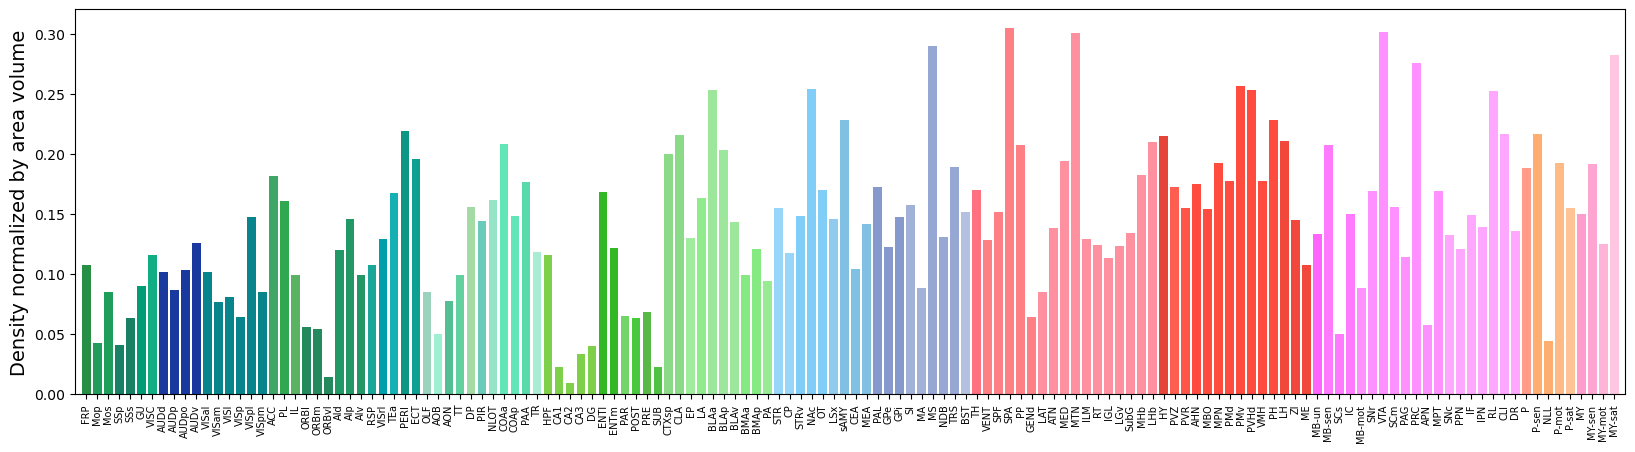

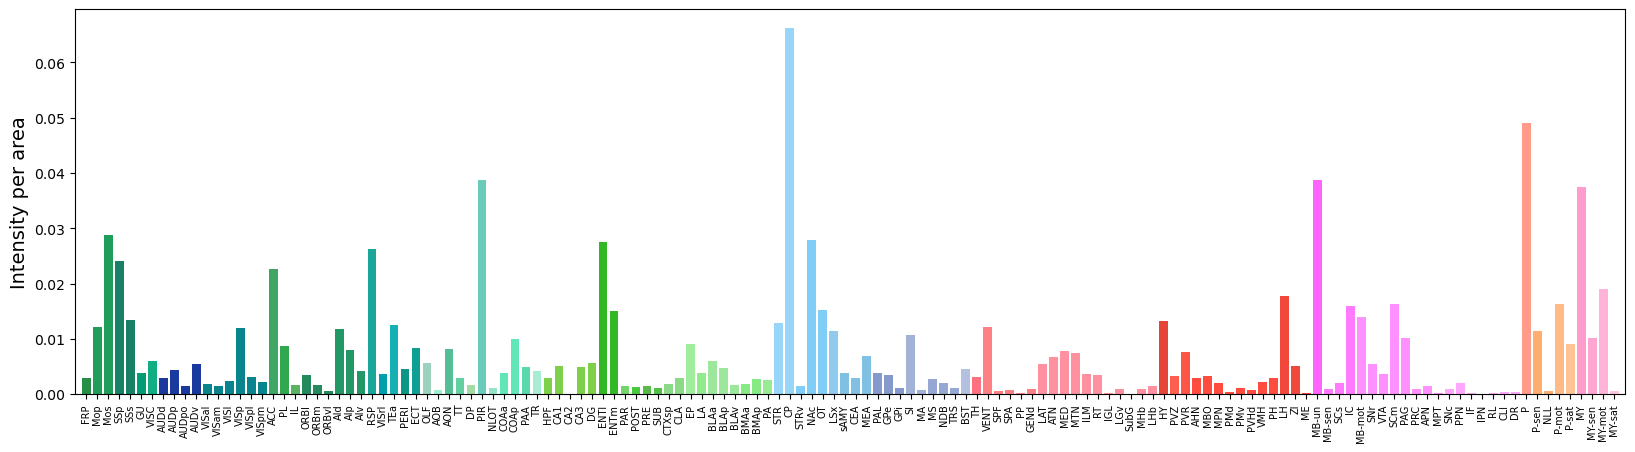

In [12]:
# this plots the quantifications
# The line below is to see the plots in the browser; does not work with interact_stack_overlay_areas
%matplotlib inline 

plt.figure(figsize = [20,5])
plt.bar(np.arange(len(model_results)),np.array(model_results.density),color = model_results.color)
plt.xticks(np.arange(len(model_results)),model_results.acronym,rotation = 90,fontsize = 7);
plt.xlim([-1,len(model_results)])
plt.ylabel('Density normalized by area volume',fontsize = 14)

plt.figure(figsize = [20,5])
plt.bar(np.arange(len(model_results)),model_results.count_pixels/np.sum(model_results.count_pixels),
        color = model_results.color)
plt.xticks(np.arange(len(model_results)),model_results.acronym,rotation = 90,fontsize = 7);
plt.xlim([-1,len(model_results)])
plt.ylabel('Intensity per area',fontsize = 14);

In [15]:
# display the refined model and the atlas
%matplotlib qt
atlas,ontology,header = read_atlas()
interact_stack_overlay_areas(refined_model,atlas)


In [ ]:
# You can use this to check that the rotation makes sense
tt = rotate_stack(stack.downsampled_stack[0],*res['angles']) # Performs the rotation
interact_show_stack(tt)  # visualizes the stack